In [1]:
!pip install -q diffusers transformers xformers git+https://github.com/huggingface/accelerate.git peft==0.7.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 897.1 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


To process different conditionings depending on the chosen ControlNet, we also need to install some
additional dependencies:
- [OpenCV](https://opencv.org/)
- [controlnet-aux](https://github.com/patrickvonplaten/controlnet_aux#controlnet-auxiliary-models) - a simple collection of pre-processing models for ControlNet

In [2]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.25.post1 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# FULL MODEL

We will use the famous painting ["Girl With A Pearl"](https://en.wikipedia.org/wiki/Girl_with_a_Pearl_Earring) for this example. So, let's download the image and take a look:

In [71]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "/content/Kutuzov2_by_Daw.jpg"
)

image1 = load_image(
    "/content/download (6).jpeg"
)

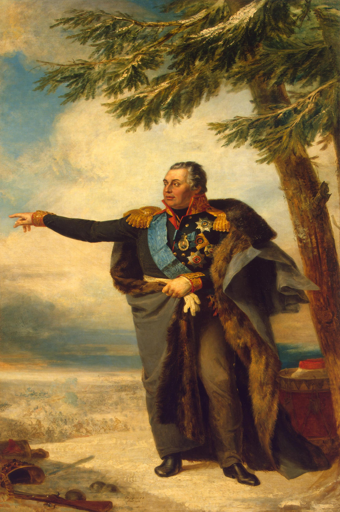

In [72]:
size = (340, 512)
image = image.resize(size)
image

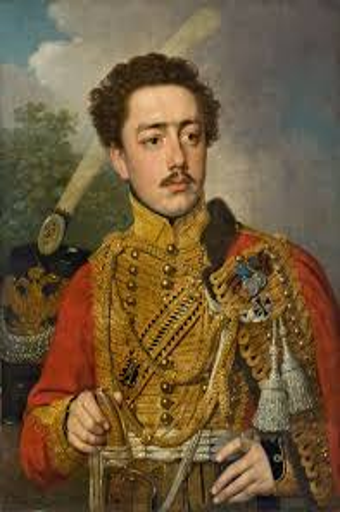

In [73]:
size = (340, 512)
image1 = image1.resize(size)
image1

Next, we will put the image through the canny pre-processor:

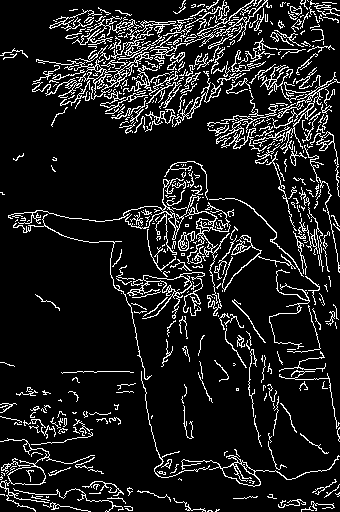

In [74]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

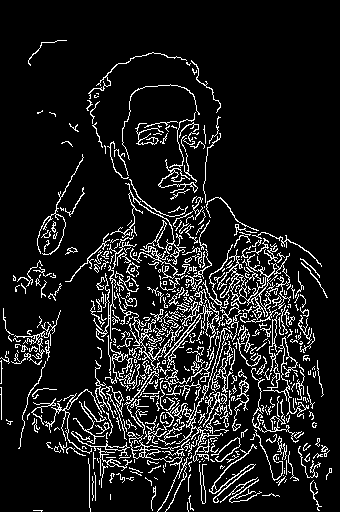

In [75]:
image1 = np.array(image1)

low_threshold = 100
high_threshold = 200

image1 = cv2.Canny(image1, low_threshold, high_threshold)
image1 = image1[:, :, None]
image1 = np.concatenate([image1, image1, image1], axis=2)
canny_image1 = Image.fromarray(image1)
canny_image1

As we can see, it is essentially edge detection.

Now, we load [runwaylml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) as well as the [ControlNet model for canny edges](https://huggingface.co/lllyasviel/sd-controlnet-canny). The models are loaded in half-precision (`torch.dtype`) to allow for fast and memory-efficient inference.

In [76]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             torch_dtype=torch.float16).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "/content/drive/MyDrive/experiment_dauni_2_400",
    controlnet=controlnet,
    torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [77]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [78]:
pipe.enable_model_cpu_offload()

In [79]:
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/35 [00:00<?, ?it/s]

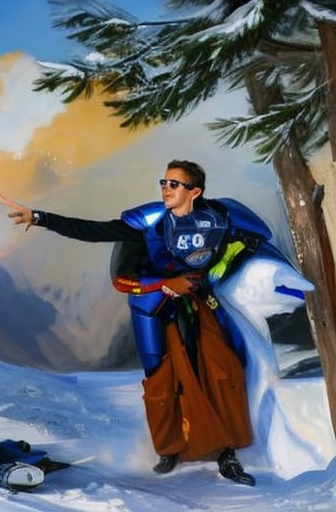

In [80]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed, 4K, raw, hrd, hd, high quality, realism, sharp focus"
prompt = [t + prompt for t in ["a photo of sks man face"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["naked, nsfw, deformed, fat, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry"],
    generator=generator,
    num_inference_steps=35,
)

image_grid(output.images, 1, 1)

  0%|          | 0/35 [00:00<?, ?it/s]

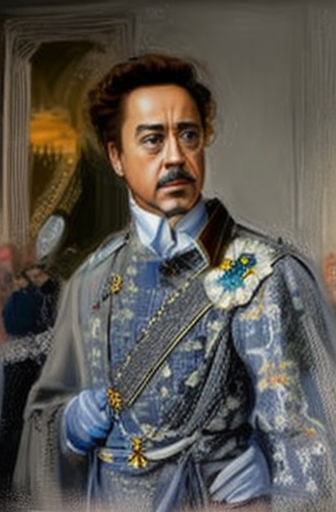

In [81]:
prompt = ", best quality, extremely detailed, 4K, raw, hrd, hd, high quality, realism, sharp focus"
prompt = [t + prompt for t in ["a photo of sks man face"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image1,
    negative_prompt=["naked, nsfw, deformed, fat, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry"],
    generator=generator,
    num_inference_steps=35,
)

image_grid(output.images, 1, 1)

## Pose control

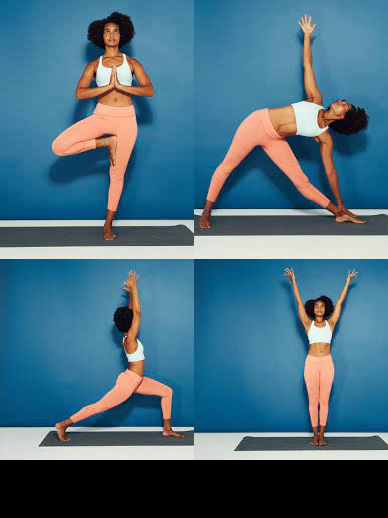

In [37]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url)
    for url in urls
]

image_grid(imgs, 2, 2)

Now let's extract yoga poses using the OpenPose pre-processors that are handily available via `controlnet_aux`.

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

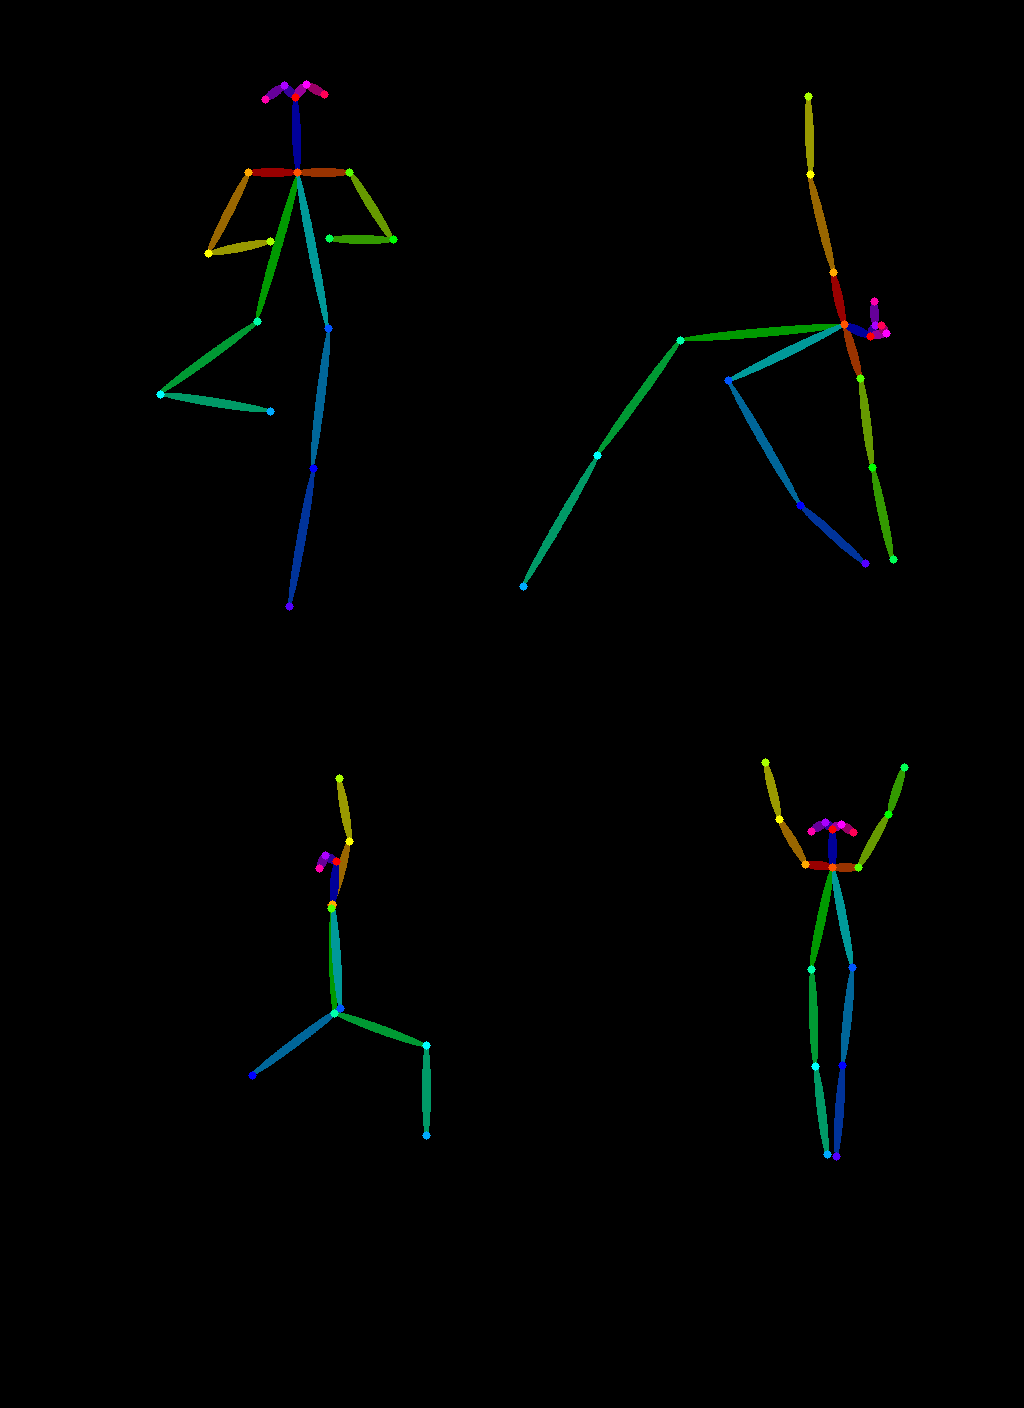

In [38]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

To use these yoga poses to generate new images, let's create a [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose). We will generate some super-hero images but in the yoga poses shown above. Let's go 🚀

In [39]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "/content/drive/MyDrive/experiment_dauni_2_400"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
).to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload()
# pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Now it's yoga time!

  0%|          | 0/50 [00:00<?, ?it/s]

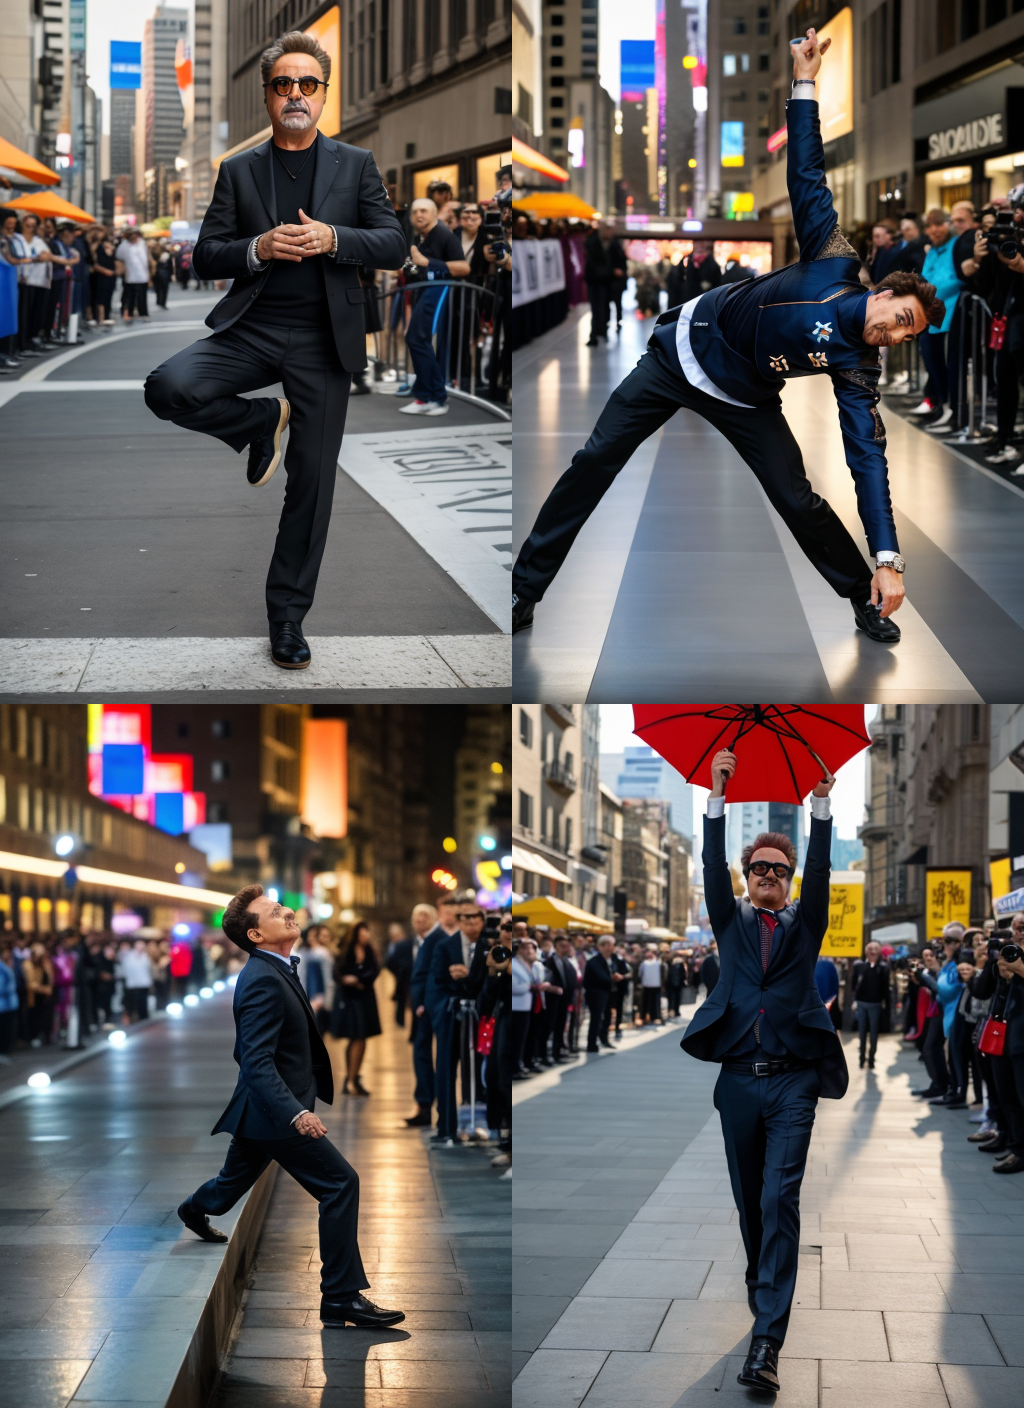

In [47]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "a photo of sks man face, best quality, extremely detailed, 4K, raw, hrd, hd, high quality, realism, sharp focus"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["lowres, bad anatomy, worst quality, low quality, deformed face, bad face, naked, nsfw, deformed, fat, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry"] * 4,
    generator=generator,
    num_inference_steps=50,
)
image_grid(output.images, 2, 2)

#LORA

We will use the famous painting ["Girl With A Pearl"](https://en.wikipedia.org/wiki/Girl_with_a_Pearl_Earring) for this example. So, let's download the image and take a look:

In [82]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "/content/Kutuzov2_by_Daw.jpg"
)

image1 = load_image(
    "/content/download (6).jpeg"
)

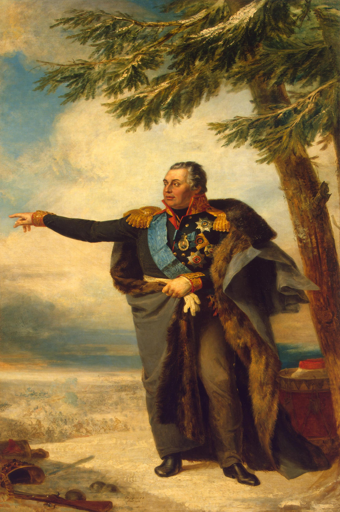

In [83]:
size = (340, 512)
image = image.resize(size)
image

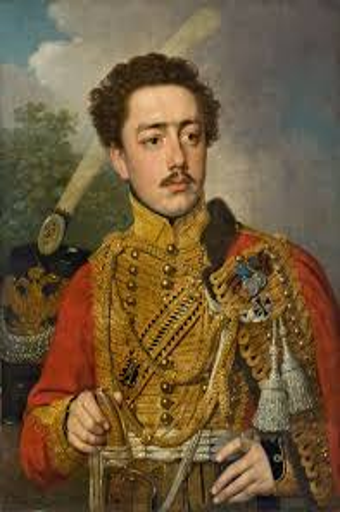

In [84]:
size = (340, 512)
image1 = image1.resize(size)
image1

Next, we will put the image through the canny pre-processor:

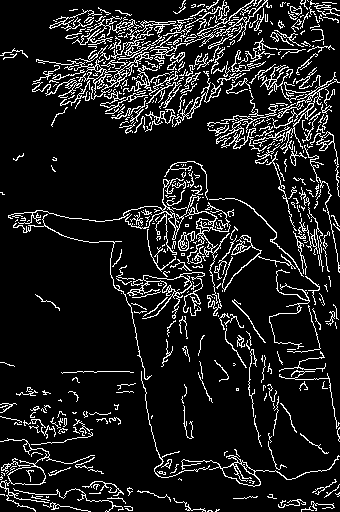

In [85]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

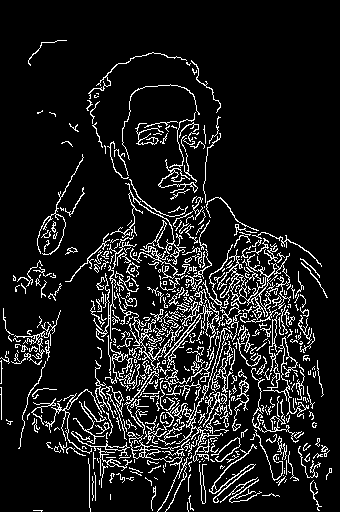

In [86]:
image1 = np.array(image1)

low_threshold = 100
high_threshold = 200

image1 = cv2.Canny(image1, low_threshold, high_threshold)
image1 = image1[:, :, None]
image1 = np.concatenate([image1, image1, image1], axis=2)
canny_image1 = Image.fromarray(image1)
canny_image1

As we can see, it is essentially edge detection.

Now, we load [runwaylml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) as well as the [ControlNet model for canny edges](https://huggingface.co/lllyasviel/sd-controlnet-canny). The models are loaded in half-precision (`torch.dtype`) to allow for fast and memory-efficient inference.

In [91]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch


controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             torch_dtype=torch.float16).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "/content/drive/MyDrive/CyberRealistic",
    controlnet=controlnet,
    torch_dtype=torch.float16).to("cuda")

pipe.load_lora_weights("/content/drive/MyDrive/experiment_dauni_lora_rank8/pytorch_lora_weights.safetensors")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [88]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [89]:
pipe.enable_model_cpu_offload()

In [90]:
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/35 [00:00<?, ?it/s]

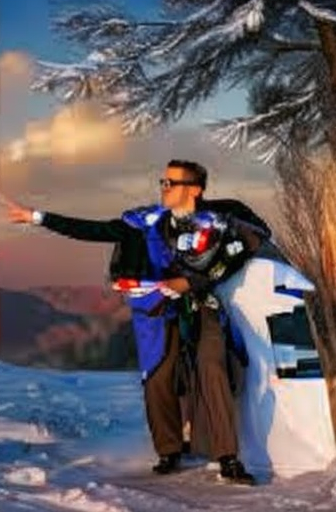

In [92]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed, 4K, raw, hrd, hd, high quality, realism, sharp focus"
prompt = [t + prompt for t in ["a photo of sks man face"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["naked, nsfw, deformed, fat, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry"],
    generator=generator,
    num_inference_steps=35,
)

image_grid(output.images, 1, 1)

  0%|          | 0/35 [00:00<?, ?it/s]

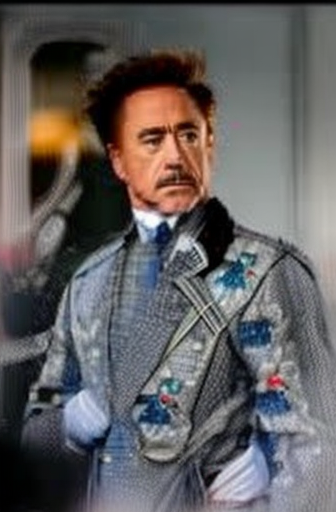

In [93]:
prompt = ", best quality, extremely detailed, 4K, raw, hrd, hd, high quality, realism, sharp focus"
prompt = [t + prompt for t in ["a photo of sks man face"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image1,
    negative_prompt=["naked, nsfw, deformed, fat, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry"],
    generator=generator,
    num_inference_steps=35,
)

image_grid(output.images, 1, 1)

## Pose control

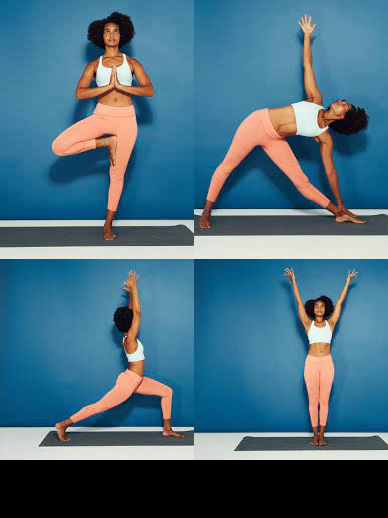

In [94]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url)
    for url in urls
]

image_grid(imgs, 2, 2)

Now let's extract yoga poses using the OpenPose pre-processors that are handily available via `controlnet_aux`.

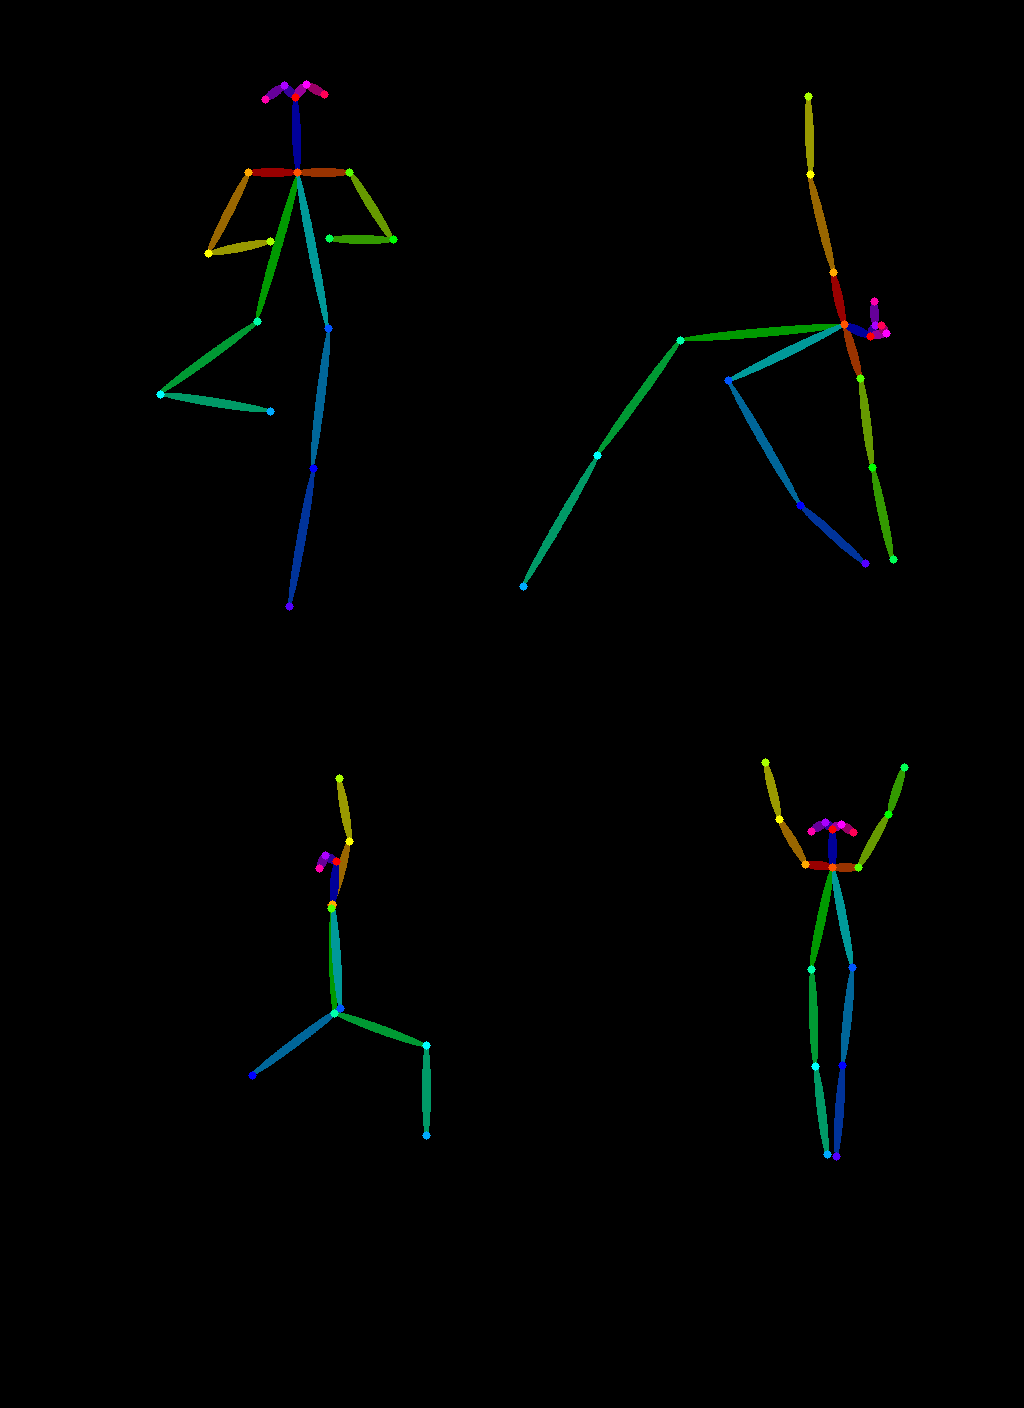

In [95]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

To use these yoga poses to generate new images, let's create a [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose). We will generate some super-hero images but in the yoga poses shown above. Let's go 🚀

In [96]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "/content/drive/MyDrive/CyberRealistic",
    controlnet=controlnet,
    torch_dtype=torch.float16).to("cuda")

pipe.load_lora_weights("/content/drive/MyDrive/experiment_dauni_lora_rank8/pytorch_lora_weights.safetensors")
# pipe.enable_model_cpu_offload()
# pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Now it's yoga time!

  0%|          | 0/50 [00:00<?, ?it/s]

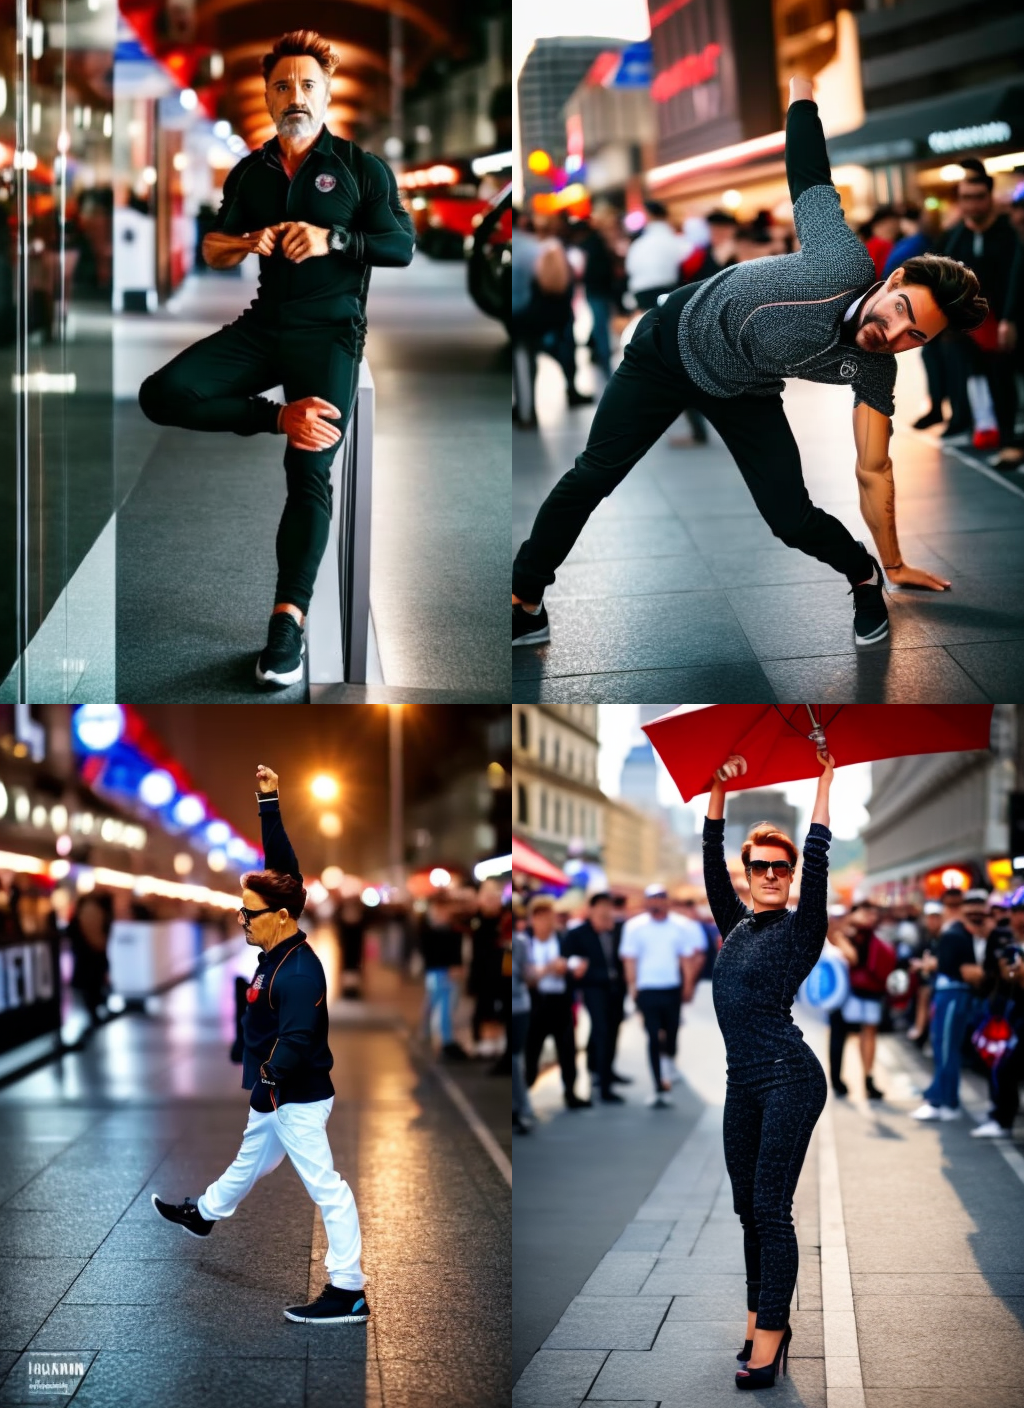

In [97]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "a photo of sks man face, best quality, extremely detailed, 4K, raw, hrd, hd, high quality, realism, sharp focus"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["lowres, bad anatomy, worst quality, low quality, deformed face, bad face, naked, nsfw, deformed, fat, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry"] * 4,
    generator=generator,
    num_inference_steps=50,
)
image_grid(output.images, 2, 2)